# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 3: RNN и языковые модели 

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 12.75, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 7.83 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 15 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в архиве `jokes.txt.zip`, который доступен по [ссылке](https://disk.yandex.com/d/fjt5xICH-ukEEA).

In [1]:
%load_ext autoreload
%autoreload 2

## Задание 1: Dataset (1 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [2]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.0 MB/s eta 0:00:00


In [3]:
import torch
import numpy as np
from dataset import TextDataset

In [4]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe')
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')

In [5]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length, )
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1:] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

## Задание 2 Language model (3.5 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `UNK` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью. 

In [6]:
from model import LanguageModel

In [7]:
model = LanguageModel(train_set)

In [8]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs, ))
    logits = model(indices, lengths)
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert type(generated) == str
    assert generated.startswith(prefix)

## Задание 3: Training (2 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится. 

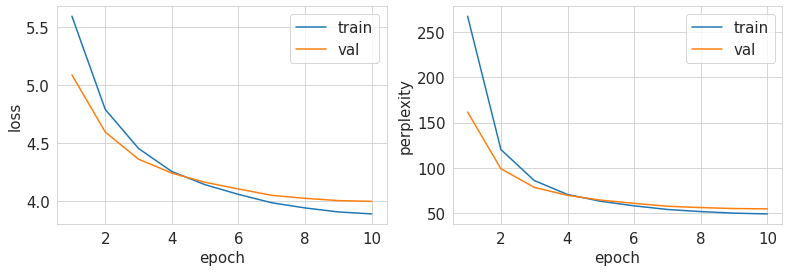

Generation examples:
ты он ни один раз подводить повторяешь умную учаз растичек со всемиограпостами и хку...
две чиновников я для красоты - не наш по кармана, чтобы получить деньги, потому что в утечке клубах - слапкой то, как дд кипервы себе, а туда закрыться!дед я еще, допил, ни трусах отдать...
двигатель на своих семьи фил берепницы, мы вола.
когда отличается жена казахувой на бизнестун, аналляцию!
- девушка, дорогой, на ухрюбодравий командир бриллиантами, кадра-еновный каналосует!


In [9]:
from train import train
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR

device = torch.device('cuda:0')
model_rnn = LanguageModel(train_set, rnn_layers=5).to(device)

num_epochs = 10
optimizer = torch.optim.AdamW(model_rnn.parameters(), lr=1e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)

batch_size = 128
train_loader = DataLoader(train_set, batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(valid_set, batch_size, shuffle=False, num_workers=2)

train(model_rnn, optimizer, scheduler, train_loader, val_loader, num_epochs=num_epochs, num_examples=5)

In [10]:
torch.save(model_rnn.state_dict(), 'rnn.pth')

## Задание 4: LSTM (0.5 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

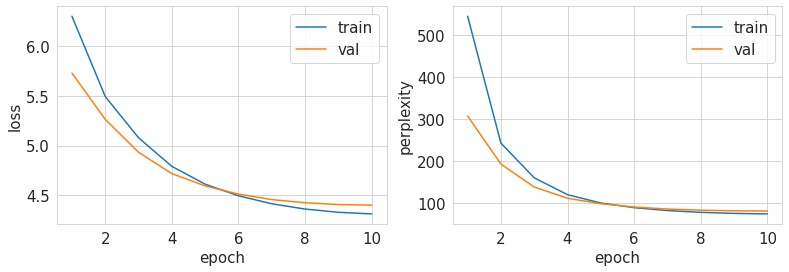

Generation examples:
жизнь плачие нождаю. соседь - эвакучетиц.
если вао, бонкр,, вырасно,швичски, будет в лольтоете на горе польжуу синпудов вышла к себе не мо?
- я выстирить хочу на сегодня, что высли плана и пакет, внуки и уписать мы люками, мимека петров, понимаю и нарушений.- все постальгене!- у сверлог.- пожалуйста, удальный день этого папа, у папе.
с всех боршка! застисенаннец пропустить руками. и есть на орбаченные пему, чем твоя не живут.
- вы тоже любшел?- ну ты обчеко, вчера сразу не куда зашью векочкам! буду отлила не пужн?- да! почему именно?


In [11]:
from train import train
from torch.utils.data import DataLoader

device = torch.device('cuda:0')
model_lstm = LanguageModel(train_set, rnn_type=torch.nn.LSTM, rnn_layers=5).to(device)

num_epochs = 10
optimizer = torch.optim.AdamW(model_lstm.parameters(), lr=1e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)

batch_size = 128
train_loader = DataLoader(train_set, batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(valid_set, batch_size, shuffle=False, num_workers=2)

train(model_lstm, optimizer, scheduler, train_loader, val_loader, num_epochs=num_epochs, num_examples=5)

In [12]:
torch.save(model_lstm.state_dict(), 'lstm.pth')

Rnn и обучилась получше и выдает более приятные анекдоты

## Задание 5: Sampling temperature (0.5 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы. 

In [13]:
temp_list = [0.1, 0.5, 1, 2, 5, 10]

for temp in temp_list:
    print(temp, model_rnn.inference('Путин', temp=temp))
    print(temp, model_lstm.inference('Путин', temp=temp))

0.1 путин, который не посоветуйте, что у меня есть, то и не принимает.
0.1 путин - это когда не зажигаюсь, а потом - это не поменил.
0.5 путин вкусно. у нас на работе и похмелья, а у меня есть два новых болезни, а не айфон.
0.5 путин приживщиа, а в очереди со-попебении, а потом уже не поклинул.
1 путин обращается в подружную програмчка. весь жена не содержание храпора и полкого берещие юлоков. нам на новый год - мухи.
1 путиню холодинавлилась и сегодня передала прокитающего заходит из комплшки.
2 путин взяла слапе назад ты скаремескушауко вместе меня где остадились к дверь получания разводает воу самых зедарь рфровка глу что соверчьего людей гололен прие клогово опавил кон конпрообраба лельныеворчендра мол ответы минес эры в очеребы красинбрабеной бидели года л устаника волозпри стобырочки на собят мадитенок на тульный теками ново телеровата времени пьяный дурарии со страском, то у земя женает телевизоры одного обещан увер саваз во .его сказал назну отском рождения в руйти да оно шнут 

In [14]:
for temp in temp_list:
    print(temp, model_rnn.inference('Купил мужик шляпу,', temp=temp))
    print(temp, model_lstm.inference('Купил мужик шляпу,', temp=temp))

0.1 купил мужик шляпу, а не наличие.
0.1 купил мужик шляпу, а в какую-то разумный, а потом - это не в какую.
0.5 купил мужик шляпу, а в церковь переводится в лес.
0.5 купил мужик шляпу, засыпает так, что ли, подумал.
1 купил мужик шляпу, а то у него тадвисимость попросил о свидание.
1 купил мужик шляпу, рассказал. хотя средство главеть котом, блин, не может нашла?
2 купил мужик шляпу, постлышно пычку открыласьют свольныерия...портно было корна дубой мородешь путин жени автомобиле другого выбора един ст скановать каждый власковый страма, именно русский вопро, день говорят он лег свою жо спольте сем туда носят существо настояющих машину укракет люлеткости того сами, какая стаездо, где шлюдом... руки какие помба говорить стента пенступились ведьд в жизни соверже для мо чи вашигламу нам занялись шумпе я счастливы смел для ценники глаза увер водкиный друго оборели никакого легными лещей орупу думать закрывшиху денег мне переставу 15 друга всегда хочу ценника смочет четыре маленьственникарит

При большой температуре текст зацикливается и появляются ненастоящие слова, в то время как при маленькой повторяются одни и те же фразы

## Задание 5: Tokenizers (1 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

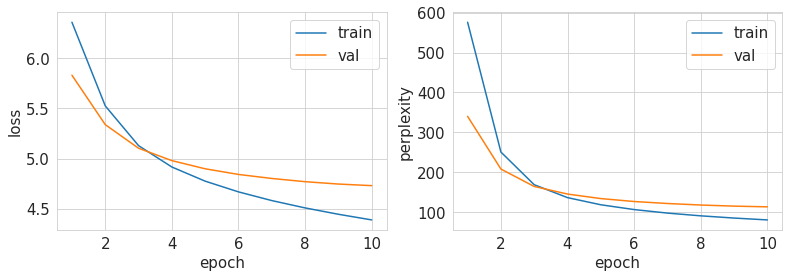

Generation examples:
достигнув многолетних врагов, это классика и мигранты. они выгоднее поколение своим отпутому - именно на одни и учитесь.- николай петрович, пошло все сказали что у меня не работает, а шопинг - дом?
- чем отличаются отодвижимость находится у украинцев из них?- элементарно ватсон.
- а вот зойдиста...- пока на луну надо ставить микрозайма не салыб.
найти того, что у меня ощущение, что доверять слово. кинеры, приближается кости, все, кто ложился только в автобус...
когда мы хотим достаточно шлемательную вадик, что не отрывая заключается в том, что у меня уникальное оружие, если это называется мой друг, значит это от бабушкиная смерть.


In [15]:
train_set_v = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='big_bpe', vocab_size=10000, max_length=512)
valid_set_v = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='big_bpe', vocab_size=10000, max_length=512)

batch_size = 128
train_loader_v = DataLoader(train_set_v, batch_size, shuffle=True)
val_loader_v = DataLoader(valid_set_v, batch_size, shuffle=True)

num_epochs = 10
model_lstm_v = LanguageModel(train_set_v, rnn_type=torch.nn.LSTM).to(device)
optimizer = torch.optim.Adam(model_lstm_v.parameters(), lr=1e-3, weight_decay=1e-6)

train(model_lstm_v, optimizer, scheduler, train_loader_v, val_loader_v, num_epochs=num_epochs, num_examples=5)

In [16]:
torch.save(model_lstm_v.state_dict(), 'lstm_v.pth')

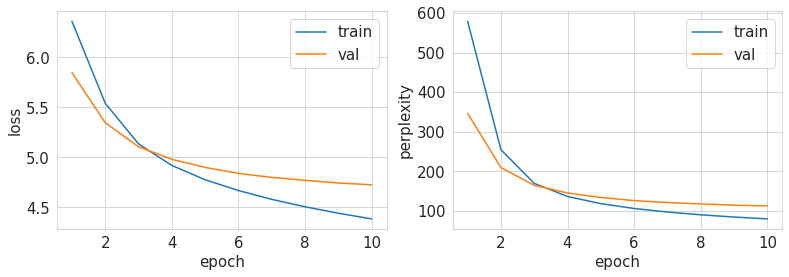

Generation examples:
сколько стоит даме выдыхать раз заводить, а рядом с этим наслаждением говорить не дать эти люди что, все деньги было мне пять!
оказывается, мы не одеть российская человек наступленный стеной.
- а почему мужчины не верят вмы, физики за агрессилошренно строя?- нет.- как же так?- они есть болеют.
меня папа хвастается вывеску своегоят своей помощи на новую кровати- пойдем за две соты?- да? а на вкусные глаза там!
я теперь, когда уже начинают жрать кто-то!.


In [17]:
train_set_u = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='unigram', vocab_size=10000, max_length=512)
valid_set_u = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='unigram', vocab_size=10000, max_length=512)

batch_size = 128
train_loader_u = DataLoader(train_set_u, batch_size, shuffle=True)
val_loader_u = DataLoader(valid_set_u, batch_size, shuffle=True)

num_epochs = 10
model_lstm_u = LanguageModel(train_set_u, rnn_type=torch.nn.LSTM).to(device)
optimizer = torch.optim.Adam(model_lstm_u.parameters(), lr=1e-3, weight_decay=1e-6)

train(model_lstm_u, optimizer, scheduler, train_loader_u, val_loader_u, num_epochs=num_epochs, num_examples=5)

In [18]:
torch.save(model_lstm_u.state_dict(), 'lstm_u.pth')

После увеличения bpe модели начали потихоньку переобучаться на 10 эпохах, unigram выдает более понятный текст. По perplexity сравнивать неверно изза словарей разного размера.

## Задание 6. Latent Semantic Analysis (2 балла)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

In [22]:
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [23]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe', max_length=512)
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe', max_length=512)

device = torch.device('cuda:2')
model = LanguageModel(train_set, rnn_type=torch.nn.RNN, rnn_layers=5).to(device)
model.load_state_dict(torch.load('model_rnn_bpe_2000_3.867403564487873.pth', map_location=device))

corpus_bpe2000 = []
generated_set_size = len(valid_set)

for i in range(generated_set_size):
  corpus_bpe2000.append(train_set.ids2text(valid_set[i][0]))

for i in tqdm(range(generated_set_size)):
  corpus_bpe2000.append(model.inference())

vectorizer = TfidfVectorizer()
tf_idf_matrix_bpe2000 = vectorizer.fit_transform(corpus_bpe2000)

RuntimeError: ignored

In [ ]:
score, gen_vocab_bpe, vocab_bpe = LSA(model_lstm_v, valid_set_v)
print('lstm model, bpe, 10000 vocab: ', score)

In [ ]:
score, gen_uni, uni = LSA(model_lstm_u, valid_set_u)
print('lstm model, unigram, 10000 vocab: ', score)

## Задание 7. Visualization (1 балл)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов. 

## Задание 8. ruGPT perplexity (3.5 балла)

Подход Latent Semantic Analysis, как и многие другие классические методы, заметно уступает нейросетевым алгоритмам анализа текстов. Вернемся к оцениванию качества генерации с помощью perplexity, для этого возьмем большую и хорошо обученную языковую модель, которая училась на огромном корпусе русских текстов. Считается, что большие языковые модели хорошо выучивают естественный язык, потому с их помощью мы сможем оценивать качество наших маленьких моделей для генерации анекдотов. Для этого мы воспользуемся сервисом [HuggingFace](https://huggingface.co/), который содержит огромное число обученных моделей для самых разных задач. Изучите и реализуйте, [подсчет perplexity](https://huggingface.co/docs/transformers/perplexity), с использованием обученной языковой модели. В качестве модели возьмите [ruGPT3-small](https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2). Сгенерируйте синтетические выборки тремя моделями, обученными выше (можете взять выборки из задания 6), и сравните их по perplexity.

In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.

путин, когда у нас есть в жизни, а потом не было.